In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('white')

# Load the data
features = ['loan_amnt', 'annual_inc', 'term', 'emp_length', 'loan_status']
a = pd.read_csv('../accepted_2007_to_2018Q4.csv', usecols=features)


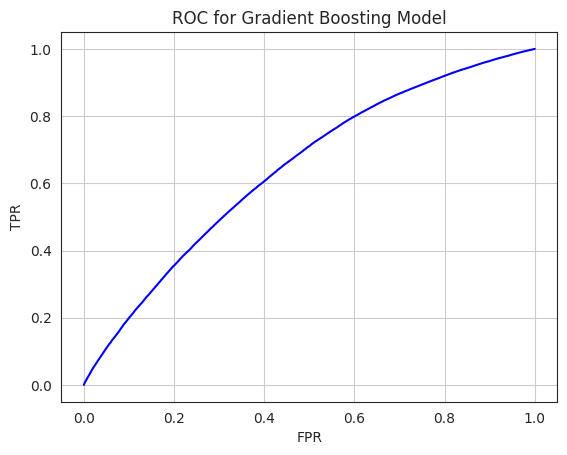

ROC-AUC-score for Gradient Boosting Model: 0.6427160049140324


In [3]:
# Preprocess the data
full_set = a.query("loan_status in ('Fully Paid', 'Charged Off')").copy()
full_set.dropna(subset=['emp_length'], inplace=True)

# Transform our Label 'loan_status' and other columns
full_set['loan_status'] = full_set['loan_status'].replace({'Fully Paid': 1, 'Charged Off': 0})
full_set['term'] = full_set['term'].replace({' 36 months': 36, ' 60 months': 60})
full_set['emp_length'] = full_set['emp_length'].map(lambda x: x.split(' ')[0])
full_set['emp_length'] = full_set['emp_length'].map(lambda x: str(x).replace('+', '').replace('<', '0'))

# Define features and target
model_features = list(full_set.columns)
model_features.remove('loan_status')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    full_set[model_features],
    full_set['loan_status'],
    random_state=42
)

# Build the Gradient Boosting model pipeline
scaler = MinMaxScaler()
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

pipeline_gb = Pipeline([
    ('scaler', scaler),
    ('gb_model', gb_model)
])

# Fit the model to the training data
pipeline_gb.fit(X_train, y_train)

# Test Model - Evaluate the Gradient Boosting model
test_probas_gb = pipeline_gb.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, test_probas_gb)
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='blue')
plt.title('ROC for Gradient Boosting Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

# Calculate ROC-AUC score for Gradient Boosting
print('ROC-AUC-score for Gradient Boosting Model:', roc_auc_score(y_test, test_probas_gb))


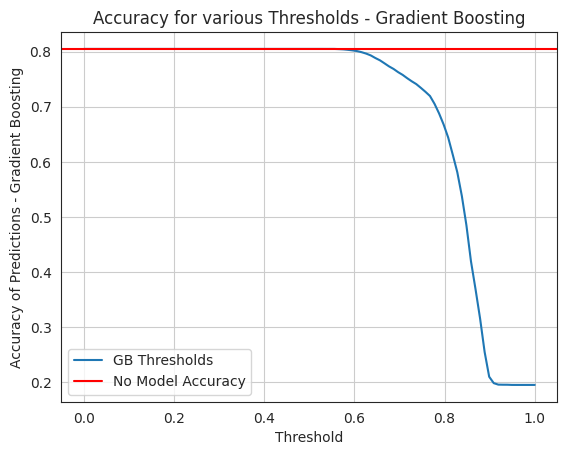

Gradient Boosting Model Accuracy with 0.7 threshold: 0.7610767287653931


In [4]:
# Compute accuracy at various thresholds for Gradient Boosting
def compute_accuracy_for_thresholds(data, thresholds=np.linspace(0, 1, 100)):
    accuracies = []
    for threshold in thresholds:
        preds = data['preds'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = accuracy_score(data['labels'].values, preds)
        accuracies.append(accuracy_)
    return accuracies, thresholds

X_test_with_gb_preds = X_test.copy()
X_test_with_gb_preds['preds'] = test_probas_gb
X_test_with_gb_preds['labels'] = y_test

accuracies_gb, thresholds_gb = compute_accuracy_for_thresholds(X_test_with_gb_preds)

# Plot accuracy for various thresholds for Gradient Boosting
plt.figure()
plt.plot(thresholds_gb, accuracies_gb, label='GB Thresholds')
plt.axhline(y_train.mean(), color='red', label='No Model Accuracy')
plt.grid()
plt.title('Accuracy for various Thresholds - Gradient Boosting')
plt.xlabel('Threshold')
plt.ylabel('Accuracy of Predictions - Gradient Boosting')
plt.legend()
plt.show()

# Compute accuracy with a specific threshold
threshold = 0.7
gb_accuracy_score = accuracy_score(X_test_with_gb_preds['labels'].values,
                                   (X_test_with_gb_preds['preds'] > threshold).astype(int))
print(f'Gradient Boosting Model Accuracy with {threshold} threshold:', gb_accuracy_score)